# Proyecto Final: Generador de Estilo Ghibli con LoRA
**Curso:** Deep Learning y Sistemas Inteligentes
**Integrantes:** Christian Echeverría, Diego Linares y Gabriel Paz

---
### 1. Configuración del Entorno
Instalación de dependencias estándar (`diffusers`, `peft`, `transformers`) y conexión a Google Drive para recuperar los pesos entrenados.

In [13]:
# @title 1. Setup e Instalación
import os

print("Instalando librerías... (Esto tomará unos segundos)")

# Instalación LIMPIA y ESTÁNDAR (sin git clone manual)
!pip install -q diffusers transformers accelerate bitsandbytes
!pip install -q torch torchvision torchaudio
!pip install -q matplotlib
!pip install -U -q peft

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print("Entorno listo. Librerías instaladas correctamente.")

Instalando librerías... (Esto tomará unos segundos)
Mounted at /content/drive
Entorno listo. Librerías instaladas correctamente.


### 2. Metodología de Entrenamiento (Referencia)
El modelo final (`lora_ghibli_FINAL`) fue entrenado utilizando las siguientes configuraciones:
* **Dataset:** 150 imágenes curadas (100 retratos, 50 paisajes).
* **Pasos:** 1500 pasos de entrenamiento.
* **Optimizaciones:** `gradient_checkpointing` activado, `rank=16`.
* **Text Encoder:** No entrenado (para maximizar fidelidad visual).

> *Nota: Este código se incluye solo como referencia metodológica. No es necesario ejecutarlo para la demostración.*

In [15]:
# @title Código de Entrenamiento (Referencia - No Ejecutar)
# !accelerate launch diffusers/examples/dreambooth/train_dreambooth_lora.py \
#   --pretrained_model_name_or_path="waifu-diffusion/wd-1-5-beta2" \
#   --instance_data_dir="/content/dataset/Ghibli" \
#   --output_dir="/content/drive/MyDrive/Proyecto_DL/lora_ghibli_FINAL" \
#   --instance_prompt="ghibli_style" \
#   --resolution=512 \
#   --train_batch_size=1 \
#   --gradient_accumulation_steps=1 \
#   --learning_rate=1e-4 \
#   --lr_scheduler="cosine" \
#   --lr_warmup_steps=0 \
#   --max_train_steps=1500 \
#   --use_8bit_adam \
#   --rank=16 \
#   --gradient_checkpointing

### 3. Inferencia Comparativa
Generación de imágenes comparando el **Modelo Base** vs. **Nuestro Modelo (LoRA)**.
Se utiliza una semilla fija y el mismo prompt para demostrar la transferencia de estilo.

⏳ Cargando Pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


🎨 Generando imagen Base...


  0%|          | 0/30 [00:00<?, ?it/s]

🎨 Generando imagen con LoRA Ghibli...


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

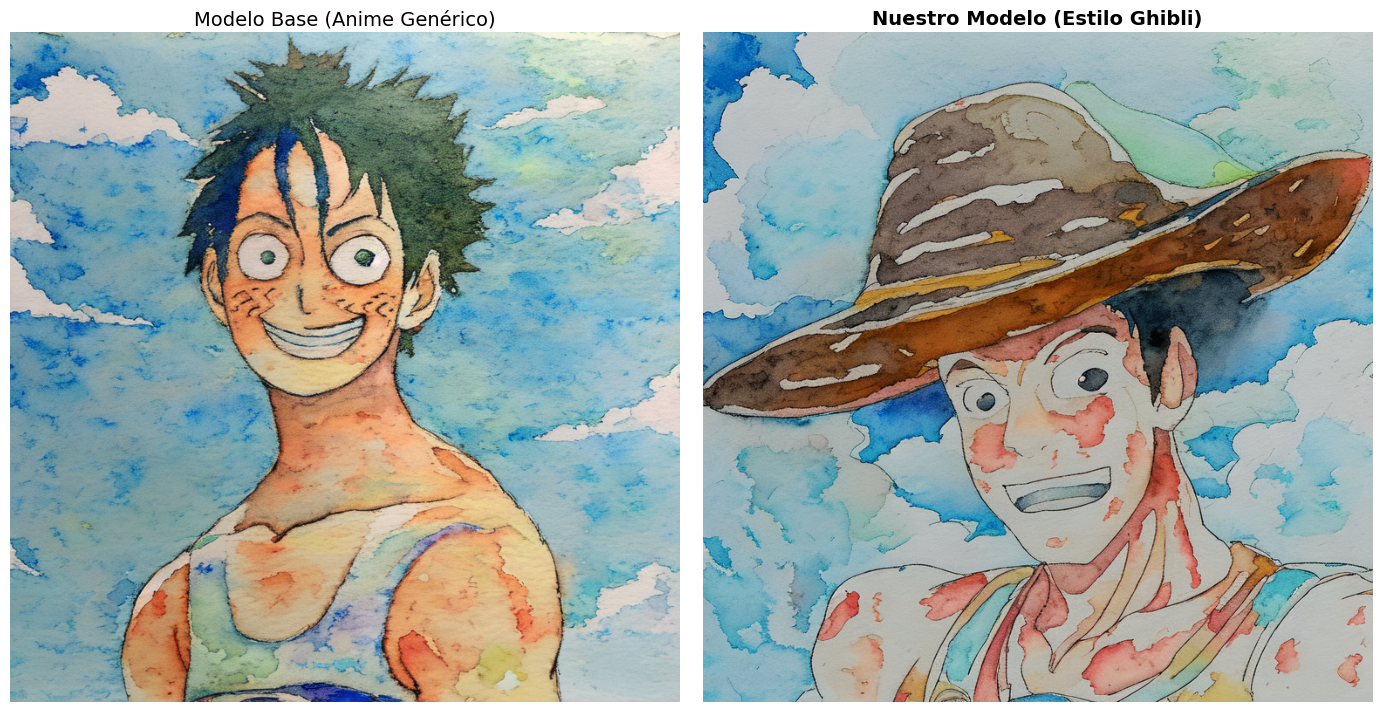

In [10]:
# @title Generación Visual (Base vs LoRA)
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt

# --- Configuración ---
MODEL_ID = "waifu-diffusion/wd-1-5-beta2"
LORA_PATH = "/content/drive/MyDrive/Proyecto_DL/lora_ghibli_FINAL"
PROMPT = "ghibli_style, (watercolor:1.2), Luffy from One Piece, smiling, blue sky background"
NEGATIVE_PROMPT = "lowres, bad anatomy, bad hands, text, error, signature, watermark, blurry"
SEED = 1996055031

print("⏳ Cargando Pipeline...")
# safety_checker=None evita falsos positivos de NSFW en la demo
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16, safety_checker=None).to("cuda")
generator = torch.Generator("cuda").manual_seed(SEED)

# 1. Generar con Modelo Base
print("🎨 Generando imagen Base...")
pipe.unload_lora_weights()
image_base = pipe(PROMPT, negative_prompt=NEGATIVE_PROMPT, generator=generator, num_inference_steps=30).images[0]

# 2. Generar con LoRA
print(f"🎨 Generando imagen con LoRA Ghibli...")
try:
    pipe.load_lora_weights(LORA_PATH)
    generator = torch.Generator("cuda").manual_seed(SEED)
    image_lora = pipe(PROMPT, negative_prompt=NEGATIVE_PROMPT, generator=generator, num_inference_steps=30, cross_attention_kwargs={"scale": 1.3}).images[0]
except Exception as e:
    print(f"⚠️ Error cargando LoRA: {e}")
    image_lora = image_base

# 3. Visualización
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(image_base)
axs[0].set_title("Modelo Base (Anime Genérico)", fontsize=14)
axs[0].axis("off")

axs[1].imshow(image_lora)
axs[1].set_title("Nuestro Modelo (Estilo Ghibli)", fontsize=14, fontweight='bold')
axs[1].axis("off")
plt.tight_layout()
plt.show()

### 4. Evaluación Cuantitativa (XAI)
Validación matemática utilizando **CLIP Score** para medir la similitud semántica entre la imagen generada y el prompt de referencia: *"anime style screenshot from a Studio Ghibli movie, watercolor style"*.

Mounted at /content/drive
Cargando Stable Diffusion...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Cargando CLIP...

--- INICIANDO EXPERIMENTO XAI ---
1. Generando con Modelo Base...


  0%|          | 0/30 [00:00<?, ?it/s]

2. Generando con Tu LoRA...


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

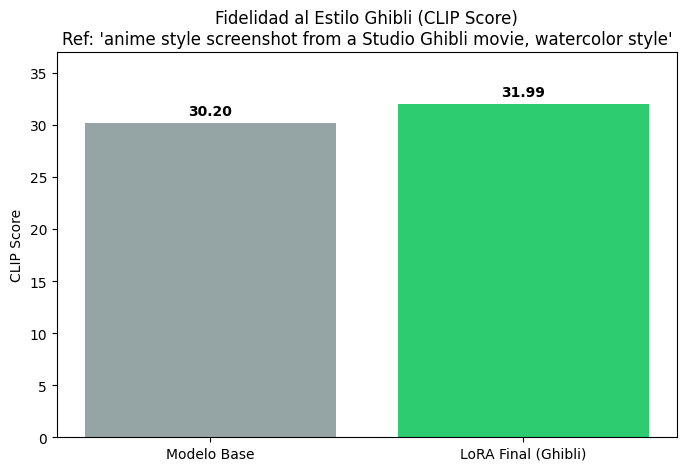

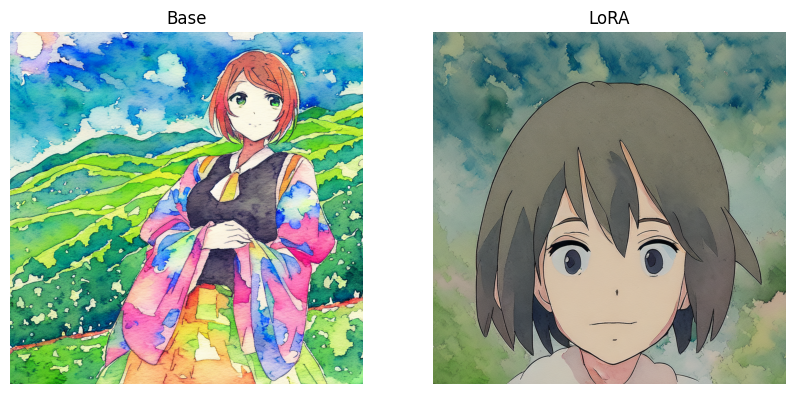

In [16]:
import torch
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# --- 1. CONFIGURACIÓN ---
drive.mount('/content/drive', force_remount=True)
PATH_AL_LORA = "/content/drive/MyDrive/Proyecto_DL/lora_ghibli_FINAL"
MODEL_ID = "waifu-diffusion/wd-1-5-beta2"

# --- 2. CARGAR MODELOS ---
print("Cargando Stable Diffusion...")
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16, safety_checker=None).to("cuda")

print("Cargando CLIP...")
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
processor_clip = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def calcular_clip_score(imagen, texto_referencia):
    inputs = processor_clip(text=[texto_referencia], images=imagen, return_tensors="pt", padding=True).to("cuda")
    outputs = model_clip(**inputs)
    return outputs.logits_per_image.item()

# --- 3. EL EXPERIMENTO CORREGIDO ---
print("\n--- INICIANDO EXPERIMENTO XAI ---")

# CAMBIO CLAVE 1: El texto contra el que evaluamos
prompt_evaluacion = "anime style screenshot from a Studio Ghibli movie, watercolor style"

# CAMBIO CLAVE 2: El prompt para generar (forzamos el estilo)
prompt_generacion = "ghibli_style, (watercolor:1.2), (anime style:1.2), 1girl, looking at viewer, green hills, sunny day"
negative_prompt = "lowres, bad anatomy, photo, realistic, 3d render"

# A. Generar con MODELO BASE
print("1. Generando con Modelo Base...")
pipe.unload_lora_weights()
generator = torch.Generator("cuda").manual_seed(123) # Seed fija
img_base = pipe(prompt_generacion, negative_prompt=negative_prompt, num_inference_steps=30, generator=generator).images[0]
score_base = calcular_clip_score(img_base, prompt_evaluacion)

# B. Generar con TU LORA
print(f"2. Generando con Tu LoRA...")
try:
    pipe.load_lora_weights(PATH_AL_LORA)
    generator = torch.Generator("cuda").manual_seed(123) # Misma seed
    # Subimos un poco la fuerza del LoRA
    img_lora = pipe(prompt_generacion, negative_prompt=negative_prompt, num_inference_steps=30, generator=generator, cross_attention_kwargs={"scale": 1.3}).images[0]
    score_lora = calcular_clip_score(img_lora, prompt_evaluacion)
except Exception as e:
    print(f"ERROR: {e}")
    score_lora = 0

# --- 4. GRÁFICO ---
plt.figure(figsize=(8, 5))
nombres = ['Modelo Base', 'LoRA Final (Ghibli)']
valores = [score_base, score_lora]
colores = ['#95a5a6', '#2ecc71'] # Gris y Verde

bars = plt.bar(nombres, valores, color=colores)
plt.title(f"Fidelidad al Estilo Ghibli (CLIP Score)\nRef: '{prompt_evaluacion}'")
plt.ylabel("CLIP Score")
plt.ylim(0, max(valores) + 5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}", ha='center', va='bottom', fontweight='bold')

plt.show()

# Mostrar las imágenes para verificar que no son fotos
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_base); axs[0].set_title("Base"); axs[0].axis("off")
axs[1].imshow(img_lora); axs[1].set_title("LoRA"); axs[1].axis("off")
plt.show()